# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

In [192]:
df = pd.read_csv('data/user-item-interactions.csv', index_col=0, dtype={'article_id':'str'})
df_content = pd.read_csv('data/articles_community.csv', index_col=0)

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45993 entries, 0 to 47581
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  45993 non-null  object
 1   title       45993 non-null  object
 2   email       45976 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [194]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [195]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [196]:
interactions_per_user = df.groupby('email')[['article_id']].count().reset_index()

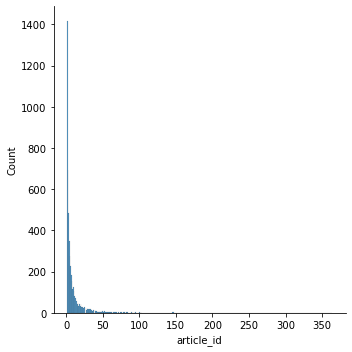

In [197]:
sns.displot(x='article_id', data=interactions_per_user)

In [198]:
interactions_per_user.describe()

,article_id
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [199]:
(interactions_per_user['article_id']==1).mean()

0.27505827505827507

In [200]:
(interactions_per_user['article_id']<=3).mean()

0.504079254079254

In [201]:
(interactions_per_user['article_id']<=5).mean()

0.6260683760683761

In [202]:
interactions_per_user['article_id'].max()

364

In [203]:
np.quantile(interactions_per_user['article_id'],0.5)

3.0

In [204]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.quantile(interactions_per_user['article_id'],0.5) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = interactions_per_user['article_id'].max() # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [205]:
df_content = df_content.drop_duplicates(subset='article_id')

In [206]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [207]:
# A
unique_articles = df['article_id'].nunique()
unique_articles

714

In [208]:
# B
total_articles = df_content['article_id'].nunique()
total_articles

1051

In [209]:
# C
print((df['email'].isna()).mean())
unique_users = df['email'].drop_duplicates().nunique()

0.00036962146413584677


In [210]:
# D
print(df.drop_duplicates(subset=['article_id','email']).shape[0])

print(df.shape[0])

user_article_interactions = df.shape[0]

33682
45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [211]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [212]:
most_viewed_article_id = df['article_id'].value_counts().index[0] # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().values[0] # The most viewed article in the dataset was viewed how many times?``

In [213]:
df['article_id'].value_counts()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
1344.0      1
984.0       1
1113.0      1
675.0       1
662.0       1
Name: article_id, Length: 714, dtype: int64

In [214]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [215]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [217]:
df['article_id'].value_counts().index()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
1344.0      1
984.0       1
1113.0      1
675.0       1
662.0       1
Name: article_id, Length: 714, dtype: int64

In [245]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    df_agg = df.groupby('article_id')\
               .agg({'user_id':'count','title':'max'})\
               .sort_values(by='user_id', ascending=False)

    top_articles = df_agg['title'].values[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().index[:n]
 
    return top_articles # Return the top article ids

In [240]:
get_top_articles(3, df=df)

array(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel'], dtype=object)

In [249]:
get_top_article_ids(3, df=df)

Index(['1429.0', '1330.0', '1431.0'], dtype='object')

In [250]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new store using decision optimization'
 'apache spark lab, part 1: basic concepts'
 'analyze energy consumption in buildings'
 'gosales transactions for logistic regression model']
Index(['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0',
       '1170.0', '1162.0', '1304.0'],
      dtype='object')


In [252]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.
